In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy

In [6]:
def skeletonize(image):
    """
    Realiza a esqueletização de uma imagem binária.
    
    :param image: Imagem binária (valores 0 e 255).
    :return: Imagem do esqueleto.
    """
    # Normalizar para valores binários (0 e 1)
    img = image // 255

    # Elemento estruturante 3x3
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

    # Placeholder para o esqueleto
    skeleton = np.zeros_like(img, dtype=np.uint8)

    while True:
        # Erosão da imagem
        eroded = cv2.erode(img, kernel)

        # Dilatação do resultado erodido
        temp = cv2.dilate(eroded, kernel)

        # Subtração morfológica para obter o contorno atual
        temp = cv2.subtract(img, temp)

        # Adicionar o contorno ao esqueleto
        skeleton = cv2.bitwise_or(skeleton, temp)

        # Atualizar a imagem para a próxima iteração
        img = eroded.copy()

        # Parar se a imagem foi completamente erodida
        if cv2.countNonZero(img) == 0:
            break

    # Converter de volta para valores 0 e 255
    return skeleton * 255

def prune_skeleton(skeleton, iterations=1):
    """
    Realiza a operação de poda em um esqueleto binário.
    
    :param skeleton: Imagem binária do esqueleto (valores 0 e 255).
    :param iterations: Número de iterações para a poda.
    :return: Esqueleto podado.
    """
    # Normalizar o esqueleto para valores 0 e 1
    skeleton = skeleton // 255

    # Elemento estruturante 3x3 para calcular vizinhança
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

    for _ in range(iterations):
        # Contar os vizinhos de cada pixel
        neighbor_count = cv2.filter2D(skeleton, -1, kernel)

        # Identificar folhas: pixels com exatamente 1 vizinho
        leaves = (skeleton == 1) & (neighbor_count == 2)

        # Remover folhas do esqueleto
        skeleton[leaves] = 0

    # Converter de volta para valores 0 e 255
    return (skeleton * 255).astype(np.uint8)

def diamond_structuring_element(radius):
    # Tamanho do elemento estruturante
    size = 2 * radius + 1
    center = radius  # Centro do diamante

    # Criar a matriz com zeros
    structuring_element = np.zeros((size, size), dtype=np.uint8)

    # Preencher os valores do diamante
    for i in range(size):
        for j in range(size):
            if abs(i - center) + abs(j - center) <= radius:
                structuring_element[i, j] = 1

    return structuring_element


radius = 2
structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
diamond_element = diamond_structuring_element(4)

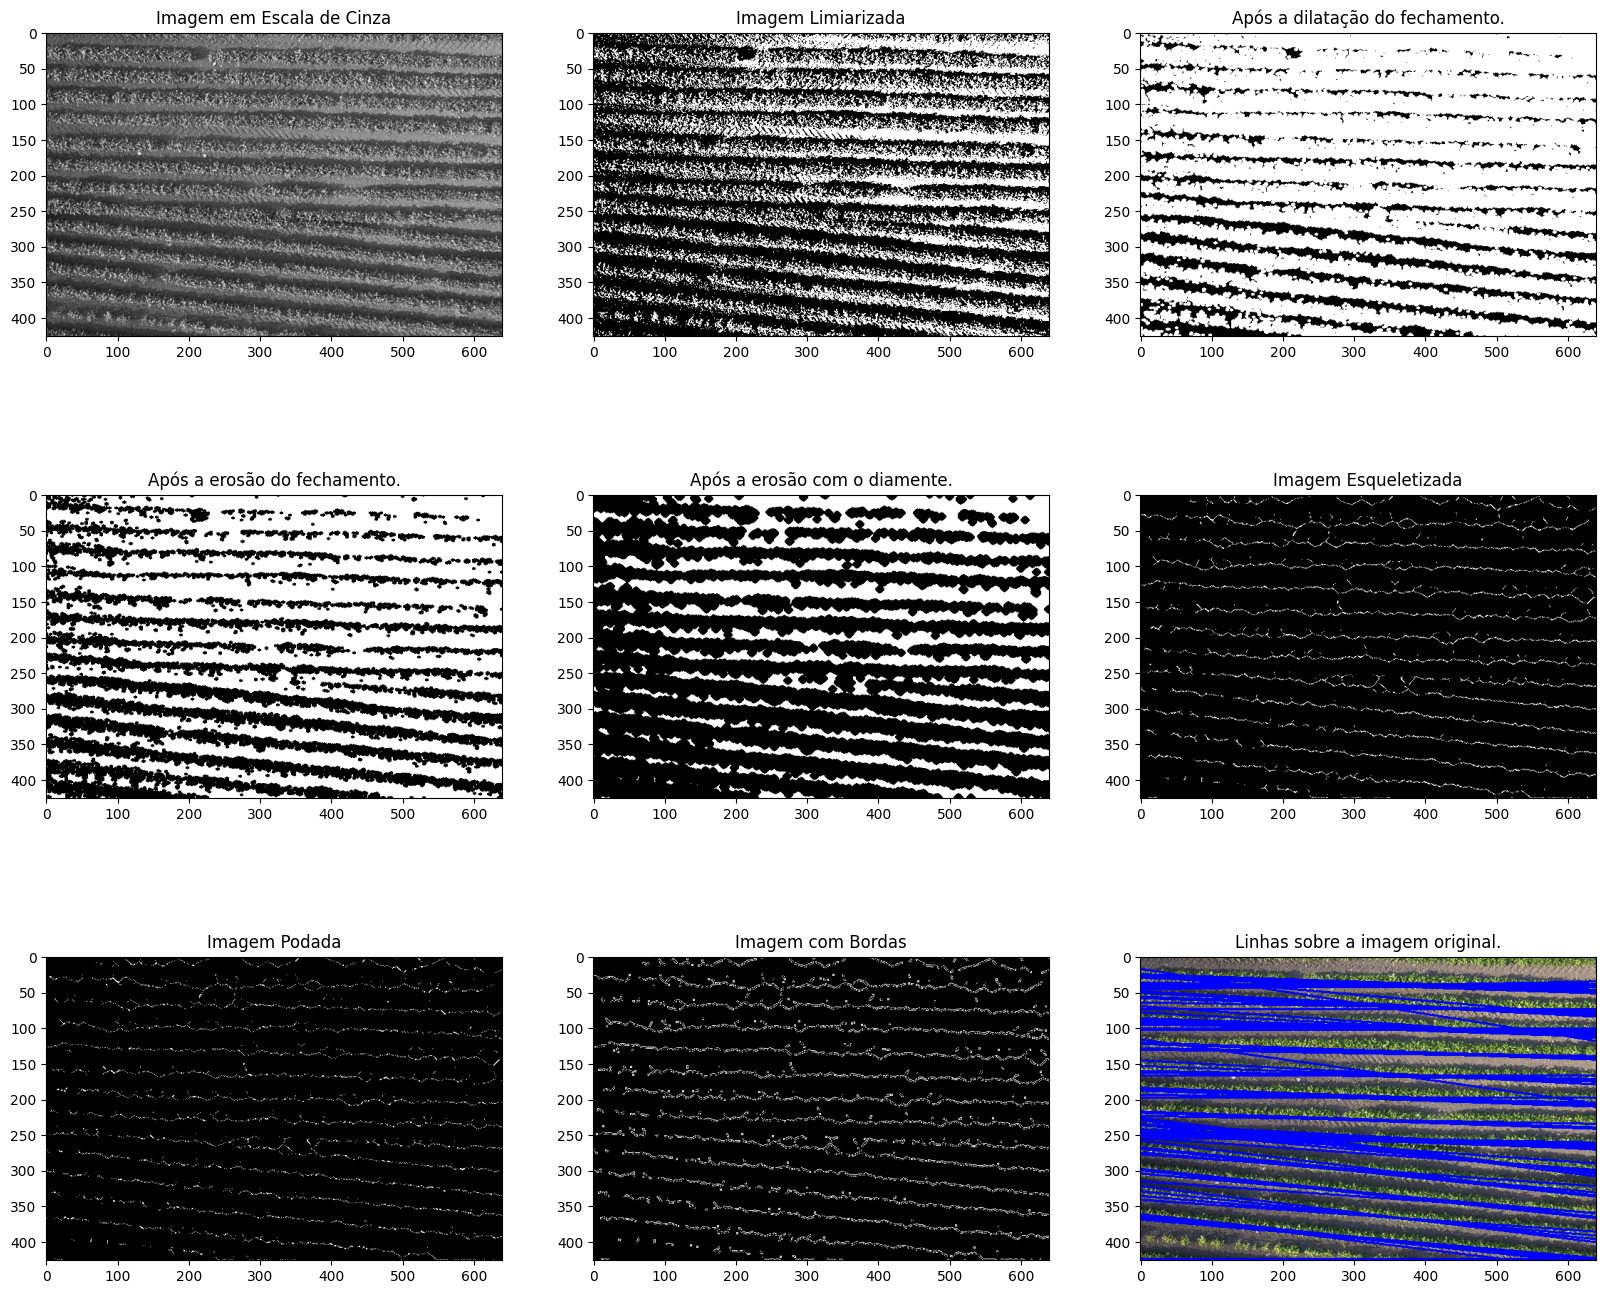

In [9]:

image_bgr = cv2.imread("image7.jpg")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
imagem = cv2.cvtColor(image_bgr, cv2.COLOR_RGB2GRAY) # Conversão para escala de cinza

thresh_value,img_thresh = cv2.threshold(imagem,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU) #OTSU

imagem_dilatada = cv2.dilate(img_thresh, structuring_element, iterations=1) # Fechamento Parte 1
imagem_fechada = cv2.erode(imagem_dilatada, structuring_element, iterations=1) # Fechamento Parte 2
imagem_erodida = cv2.erode(imagem_fechada, diamond_element, iterations=1) # Erosão

imagem_esqueleto = skeletonize(imagem_erodida) #Esqueletização
imagem_podada = prune_skeleton(imagem_esqueleto, 1) #Poda
bordas = cv2.Canny(imagem_esqueleto, 70, 100) # Detecção de bordas.


linhas = cv2.HoughLines(bordas, 1, np.pi / 180, 60, None, 0, 0) # Determinação das linhas
if linhas is not None:
    for line in linhas:
        rho, theta = line[0]
        
        #Conversão das coordenadas polares em coordenadas cartesianas.
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        
        # Desenhar a linha detectada
        cv2.line(image_rgb, (x1, y1), (x2, y2), (0, 0, 255), 2) #Desenha as linhas na imagem original colorida.
            
plt.figure(figsize=(20, 16))
plt.subplots_adjust(hspace=0.5)
plt.subplot(3,3,1)
plt.title('Imagem em Escala de Cinza')       
plt.imshow(imagem, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,3,2)
plt.title('Imagem Limiarizada')       
plt.imshow(img_thresh, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,3,3)
plt.title('Após a dilatação do fechamento.')       
plt.imshow(imagem_dilatada, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,3,4)
plt.title('Após a erosão do fechamento.')       
plt.imshow(imagem_fechada, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,3,5)
plt.title('Após a erosão com o diamente.')       
plt.imshow(imagem_erodida, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,3,6)
plt.title('Imagem Esqueletizada')       
plt.imshow(imagem_esqueleto, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,3,7)
plt.title('Imagem Podada')       
plt.imshow(imagem_podada, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,3,8)
plt.title('Imagem com Bordas')       
plt.imshow(bordas, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,3,9)
plt.title('Linhas sobre a imagem original.')       
plt.imshow(image_rgb, cmap='gray', vmin=0, vmax=255)


TypeError: Invalid shape (16072, 1, 2) for image data

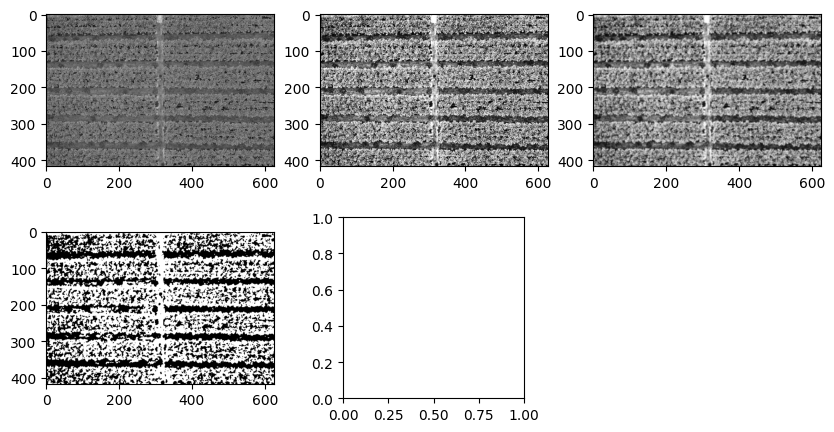

In [6]:
img = cv2.imread("image10.jpg", cv2.IMREAD_GRAYSCALE)
img_equalized = cv2.equalizeHist(img) # Equalização de uma imagem
img_blur = cv2.GaussianBlur(img_equalized,(5,5),0) # Filtro gaussiano
_,img_thresh = cv2.threshold(img_blur,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU) # Limiarização de OTSU

#img_equalized_median = cv2.medianBlur(img_equalized, 3) # Filtro de mediana
#ret2,th2 = cv2.threshold(img_equalized,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU) # Limiarização de OTSU
#dst = cv2.medianBlur(th2, 7) # Filtro de mediana
#edges = cv2.Canny(dst,0,255) #Identificação de bordas

kernel = np.ones((5, 5), np.uint8)
imagem_erodida = cv2.erode(img_thresh, kernel, iterations=1)
#imagem_dilatada = cv2.dilate(imagem, kernel, iterations=1)

imagem_fechada = cv2.morphologyEx(imagem_erodida, cv2.MORPH_CLOSE, kernel)


dst = cv2.Canny(img_equalized, 50, 200, None, 3)
lines = cv2.HoughLines(dst, 1, np.pi / 180, 150, None, 0, 0)

plt.figure(figsize=(10, 8))
plt.subplot(3,3,1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,3,2)
plt.imshow(img_equalized, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,3,3)
plt.imshow(img_blur, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,3,4)
plt.imshow(img_thresh, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,3,5)
plt.imshow(lines, cmap='gray', vmin=0, vmax=255);